# An Introduction to Gaussian Processes in PyMC3

**Christopher Fonnesbeck**  
***PyData San Luis 2017***


## Motivation

A common applied statistics task involves building regression models to characterize non-linear relationships between variables. It is possible to fit such models by assuming a particular non-linear functional form, such as a sinusoidal, exponential, or polynomial function, to describe one variable's response to the variation in another. Unless this relationship is obvious from the outset, however, it involves possibly extensive model selection procedures to ensure the most appropriate model is retained. 

Alternatively, a **non-parametric** approach can be adopted by defining a set of knots across the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. However, knot layout procedures are somewhat ad hoc and can also involve variable selection. 

A third alternative is to adopt a **Bayesian** non-parametric strategy, and directly model the unknown underlying function. For this, we can employ **Gaussian process** models.

## Bayesian Statistics

Though many of you will have taken a statistics course or two during your undergraduate (or graduate) education, most of those who have will likely not have had a course in *Bayesian* statistics. Most introductory courses, particularly for non-statisticians, still do not cover Bayesian methods at all, except perhaps to derive Bayes' formula as a trivial rearrangement of the definition of conditional probability. Even today, Bayesian courses are typically tacked onto the curriculum, rather than being integrated into the program.

In fact, Bayesian statistics is not just a particular method, or even a class of methods; it is an entirely different paradigm for doing statistical analysis.

> Practical methods for making inferences from data using probability models for quantities we observe and about which we wish to learn.
*-- Gelman et al. 2013*

A Bayesian model is described by parameters, uncertainty in those parameters is described using probability distributions.

All conclusions from Bayesian statistical procedures are stated in terms of *probability statements*

![](images/prob_model.png)

This confers several benefits to the analyst, including:

- ease of interpretation, summarization of uncertainty
- can incorporate uncertainty in parent parameters
- easy to calculate summary statistics


## Bayesian vs Classical Statistics: What's the difference?


Any statistical paradigm, Bayesian or otherwise, involves at least the following: 

1. Some **unknown quantities** about which we are interested in learning or testing. We call these *parameters*.
2. Some **data** which have been observed, and hopefully contain information about (1).
3. One or more **models** that relate the data to the parameters, and is the instrument that is used to learn.

### The Frequentist World View

![Fisher](images/fisher.png)

- The data that have been observed are considered **random**, because they are realizations of random processes, and hence will vary each time one goes to observe the system.
- Model parameters are considered **fixed**. The parameters' values are unknown, but they are fixed, and so we *condition* on them.

In mathematical notation, this implies a (very) general model of the following form:

<div style="font-size:35px">
\\[f(y | \theta)\\]
</div>

Here, the model \\(f\\) accepts data values \\(y\\) as an argument, conditional on particular values of \\(\theta\\).

Frequentist inference typically involves deriving **estimators** for the unknown parameters. Estimators are formulae that return estimates for particular estimands, as a function of data. They are selected based on some chosen optimality criterion, such as *unbiasedness*, *variance minimization*, or *efficiency*.

> For example, lets say that we have collected some data on the prevalence of autism spectrum disorder (ASD) in some defined population. Our sample includes \\(n\\) sampled children, \\(y\\) of them having been diagnosed with autism. A frequentist estimator of the prevalence \\(p\\) is:

> <div style="font-size:25px">
> \\[\hat{p} = \frac{y}{n}\\]
> </div>

> Why this particular function? Because it can be shown to be unbiased and minimum-variance.

It is important to note that new estimators need to be derived for every estimand that is introduced.

### The Bayesian World View

![Bayes](images/bayes.png)

- Data are considered **fixed**. They used to be random, but once they were written into your lab notebook/spreadsheet/IPython notebook they do not change.
- Model parameters themselves may not be random, but Bayesians use probability distribtutions to describe their uncertainty in parameter values, and are therefore treated as **random**. In some cases, it is useful to consider parameters as having been sampled from probability distributions.

This implies the following form:

<div style="font-size:35px">
\\[p(\theta | y)\\]
</div>

This formulation used to be referred to as ***inverse probability***, because it infers from observations to parameters, or from effects to causes.

Posterior distributions are calculated using **Bayes' Formula**. 

![bayes formula](images/bayes_formula.png)

The equation expresses how our belief about the value of \\(\theta\\), as expressed by the **prior distribution** \\(P(\theta)\\) is reallocated following the observation of the data \\(y\\), as expressed by the posterior distribution the posterior distribution.

The innocuous denominator \\(P(y)\\) cannot be calculated directly, and is actually the expression in the numerator, integrated over all \\(\theta\\):

<div style="font-size: 150%;">  
\\[Pr(\theta|y) = \frac{Pr(y|\theta)Pr(\theta)}{\int Pr(y|\theta)Pr(\theta) d\theta}\\]
</div>

The intractability of this integral is one of the factors that has contributed to the under-utilization of Bayesian methods by statisticians.

Bayesian inference typically proceeds by specifying a **full probability model** consisting of:

- **likelihood function** describing the sampling distribution of the data 
- **prior distribution** of unknown parameters, summarizing what is known about them before data are collected
- **transformed variables** as required by the problem

Since we are usually unable to calculate the denominator, numerical approximations are typically applied to estimate the posterior distribution.

## Bayesian Non-parametrics

Describing a Bayesian procedure as "non-parametric" is something of a misnomer. The first step in setting up a Bayesian model is specifying a full probability model for the problem at hand, assigning probability densities to each model variable. Thus, it is difficult to specify a full probability model without the use of probability functions, which are parametric! In fact, Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. Rather, Bayesian non-parametric models are **infinitely parametric**.

## Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. 

### Marginalization

First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

### Conditioning

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_{x|y}, \Sigma_{x|y})$$

where

$$\begin{align}
\mu_{x|y} &= \mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y) \\
\Sigma_{x|y} &= \Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T
\end{align}$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a **mean function** and a **covariance function**:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. 

In [1]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

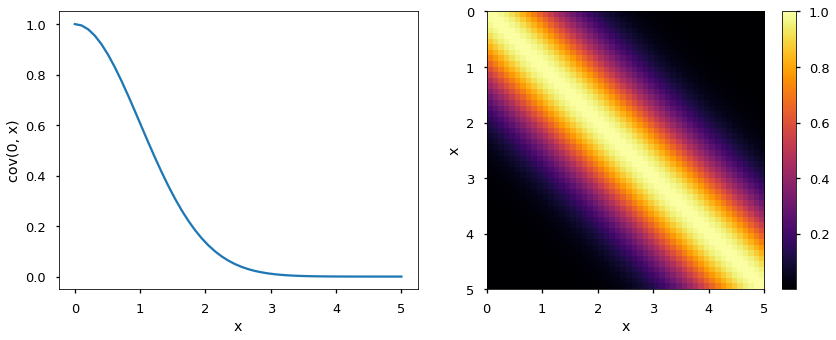

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cmap
import seaborn as sns
sns.set_context('talk')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xrange = np.linspace(0, 5)
ax1.plot(xrange, exponential_cov(0, xrange, [1, 1]))
ax1.set_xlabel('x')
ax1.set_ylabel('cov(0, x)')

z = np.array([exponential_cov(xrange, xprime, [1, 1]) for xprime in xrange])
ims = ax2.imshow(z, cmap="inferno", 
       interpolation='none', 
       extent=(0, 5, 5, 0))
ax2.set_xlabel('x')
ax2.set_ylabel('x')
plt.colorbar(ims, ax=ax2)

plt.tight_layout();

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

For example, consider just two points from a squared exponential covariance function with parameters $\theta_1=1, \theta_2=2$, sampled at locations $x_1=0$ and $x_2=-0.5$.

In [3]:
from functools import partial

K = partial(exponential_cov, params=[1, 2])

The corresponding covariance matrix is this:

In [4]:
cov = np.array([[K(0, 0), K(0, -0.5)], 
                [K(-0.5, 0), K(-0.5, -0.5)]])
cov

array([[ 1.        ,  0.77880078],
       [ 0.77880078,  1.        ]])

Let's consider a value of -1 sampled from $x_1$. According to our model, there is a dependence regarding where $x_2$ will be located, governed by the covariance of the two variables.

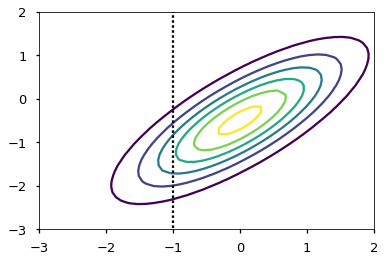

In [5]:
from matplotlib.mlab import bivariate_normal

x = np.linspace(-3.0, 3.0)
y = np.linspace(-3.0, 3.0)
X, Y = np.meshgrid(x, y)

Z = bivariate_normal(X, Y, cov[0,0], cov[1,1], 0.0, -0.5, cov[0,1])
plt.contour(X,Y,Z)
plt.vlines(-1, -4, 4, linestyles=':')
plt.xlim(-3, 2); plt.ylim(-3, 2);

We can apply the normal distribution of $x_2|x_1$ from above to see how $x_2$ is constrained:

$$p(x_2|x_1) = \mathcal{N}(\mu_{x_1} + \Sigma_{x_1 x_2}\Sigma_{x_2}^{-1}(x_2-\mu_{x_2}), 
\Sigma_{x_1}-\Sigma_{x_1 x_2}\Sigma_{x_2}^{-1}\Sigma_{x_1 x_2}^T)$$

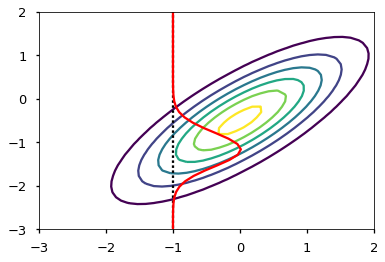

In [6]:
import scipy as sp

plt.contour(X,Y,Z)
plt.vlines(-1, -4, 4, linestyles=':')
plt.plot(sp.stats.norm(0 + (cov[1,0]/cov[1,1]) * (-1 - 0.5), cov[0,0] - cov[1,0]**2/cov[1,1]).pdf(x) - 1, x, 'r')
plt.xlim(-3, 2); plt.ylim(-3, 2);

Notice that if we change the covariance function (either the form or the parameterization), we will change the dependence among points separated by a given distance. We will look at alternate forms of the covariance function a little later on.

## Sampling from a Gaussian Process Prior

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which result in an evaluation of a function over a set of points. All we will do here is sample from the *prior* Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

And this the function that implements it:

In [7]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

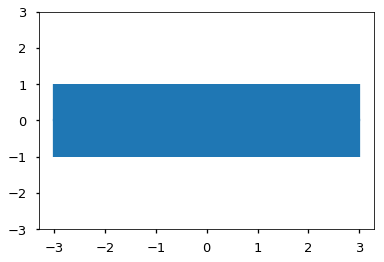

In [8]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.ylim(-3, 3);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [9]:
np.random.seed(42)

x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.4967141530112327]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [10]:
σ_1 = exponential_cov(x, x, θ)

In [11]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [12]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

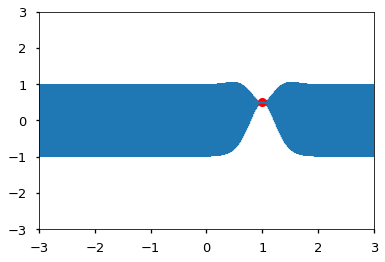

In [13]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [14]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

-0.1382640378102619

This point is added to the realization, and can be used to further update the location of the next point.

In [15]:
x.append(-0.7)
y.append(y2)

In [16]:
σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

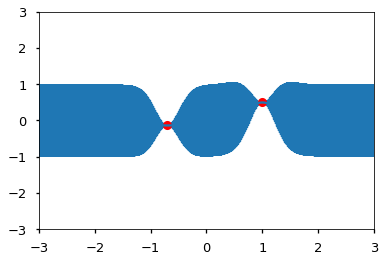

In [17]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [18]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-1.5128756 ,  0.52371713, -0.13952425, -0.93665367, -1.29343995])

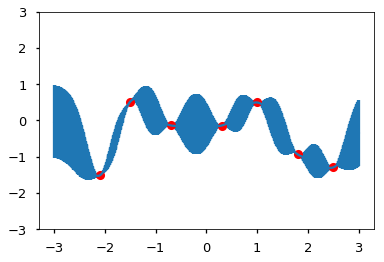

In [19]:
x += x_more
y += y_more.tolist()

σ_new = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

So as the density of points becomes high, the result will be one realization (function) from the prior GP. 

This example, of course, is trivial because it is simply a random function drawn from the prior. What we are really interested in is *learning* about an underlying function from information residing in our data. In a parametric setting, we either specify a likelihood, which we then maximize with respect to the parameters, of a full probability model, for which we calculate the posterior in a Bayesian context. Though the integrals associated with posterior distributions are typically intractable for parametric models, they do not pose a problem with Gaussian processes.

In [20]:
x = np.linspace(-3, 3, 10)
σ_n = exponential_cov(x, x, θ)

In [21]:
m, s = conditional(x, [], [], θ)
y = np.random.multivariate_normal(m, s)

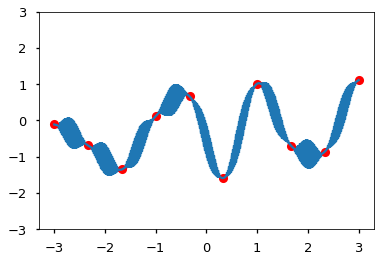

In [22]:
plt.plot(x, y, "ro")
predictions = [predict(i, x, exponential_cov, θ, σ_n, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.ylim(-3, 3);

Here is a sample of 10 realizations, predicted over a denser set of x-values:

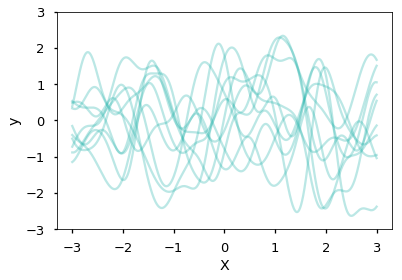

In [23]:
x = np.linspace(-3, 3) 
σ_n = exponential_cov(x, x, θ)
m, s = conditional(x, [], [], θ)

for i in range(10):
    y = np.random.multivariate_normal(m, s)
    predictions = [predict(i, x, exponential_cov, θ, σ_n, y) for i in x_pred]
    y_pred, sigmas = np.transpose(predictions)
    plt.plot(x_pred, y_pred, 'LightSeaGreen', alpha=0.3)
    plt.ylim(-3, 3)

plt.xlabel('X'); plt.ylabel('y')

---

## References

- [Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)
- Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian Data Analysis, Third Edition. CRC Press.
